# Evaluation using naively-trained discriminator

1. Train the discriminator on CIFAR10
2. Load the generator network with pretrained weights
3. Test discriminator with generated images

In [1]:
from __future__ import print_function
import pdb
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torch.autograd as autograd
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import numpy as np

In [2]:
nc = 3
batchSize=512
imageSize=32
nz=100
ngf=48
ndf=48
niter=500
lr=0.001
beta1=0.5
outf = './results_naive'

In [3]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

In [4]:
dataset = dset.CIFAR10(root="./data", download=True,
                        transform=transforms.Compose([
                        transforms.Scale(imageSize),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
                                         shuffle=True, num_workers=int(1))

Files already downloaded and verified


1. Define discriminator and generator networks

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


class _netG(nn.Module):
    def __init__(self, ngpu):
        super(_netG, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ngf, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 48 x 32 x 32
            nn.Conv2d(ngf, ngf, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 48 x 32 x 32
            nn.Conv2d(ngf, ngf, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 48 x 32 x 32
            nn.Conv2d(ngf, ngf, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 48 x 32 x 32
            nn.Conv2d(ngf, ngf, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 48 x 32 x 32
            nn.Conv2d(ngf, ngf, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 48 x 32 x 32
            nn.Conv2d(ngf, ngf, 1, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 3 x 32 x 32
            nn.Conv2d(ngf, nc, 1, 1, 0, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


# netG = _netG(1)
# netG.apply(weights_init)
# if opt.netG != '':
#     netG.load_state_dict(torch.load(opt.netG))
# print(netG)


class _netD(nn.Module):
    def __init__(self, ngpu):
        super(_netD, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*2, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*2, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*2, 1, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, 10, 1, 1, 1, bias=False),
            nn.AvgPool2d((8,8)),
            nn.Softmax()
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.squeeze()
    
netD = _netD(1)
netD.apply(weights_init)
netD.load_state_dict(torch.load('./results_naive/netD_epoch_41.pth'))
print(netD)

criterion = nn.CrossEntropyLoss()

_netD(
  (main): Sequential(
    (0): Conv2d (3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): LeakyReLU(0.2, inplace)
    (2): Conv2d (48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(0.2, inplace)
    (4): Conv2d (48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): LeakyReLU(0.2, inplace)
    (6): Conv2d (96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): LeakyReLU(0.2, inplace)
    (8): Conv2d (96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): LeakyReLU(0.2, inplace)
    (10): Conv2d (96, 96, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1), bias=False)
    (11): LeakyReLU(0.2, inplace)
    (12): Conv2d (96, 10, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1), bias=False)
    (13): AvgPool2d(kernel_size=(8, 8), stride=(8, 8), padding=0, ceil_mode=False, count_include_pad=True)
    (14): Softmax()
  )
)


In [6]:
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

In [7]:
dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!

In [8]:
input = torch.FloatTensor(batchSize, 3, imageSize, imageSize)
#fixed_noise = torch.FloatTensor(opt.batchSize, nz, 1, 1).normal_(0, 1)
label = torch.FloatTensor(batchSize)
real_label = 1
fake_label = 0

In [9]:
use_cuda = False#torch.cuda.is_available()
if use_cuda:
    netD.cuda()
    criterion.cuda()
    input, label = input.cuda(), label.cuda()

In [46]:
for epoch in range(niter):
    for i, batch in enumerate(dataloader):
        data, classes = batch[0], batch[1]
       # print(data.size())
       # print(classes.size())
        ############################
        # (1) Update D network: 
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data
        batch_size = real_cpu.size(0)
        if use_cuda:
            real_cpu = real_cpu.cuda()
        input.resize_as_(real_cpu).copy_(real_cpu)
        label.resize_(batch_size).fill_(real_label)
        inputv = Variable(input)
        if use_cuda:
            labelv = Variable(classes).cuda()
        else:
            labelv = Variable(classes)
        #print(inputv.size())
        output = netD(inputv)
        errD_real = criterion(output, labelv)
        errD_real.backward()
        D_x = output.data.mean()
        optimizerD.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f D(x): %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD_real.data[0], D_x))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)

    # do checkpointing
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))


[0/500][0/98] Loss_D: 2.1865 D(x): 0.1000
[0/500][1/98] Loss_D: 2.2062 D(x): 0.1000
[0/500][2/98] Loss_D: 2.1616 D(x): 0.1000
[0/500][3/98] Loss_D: 2.1808 D(x): 0.1000
[0/500][4/98] Loss_D: 2.1741 D(x): 0.1000
[0/500][5/98] Loss_D: 2.1819 D(x): 0.1000
[0/500][6/98] Loss_D: 2.2011 D(x): 0.1000
[0/500][7/98] Loss_D: 2.1757 D(x): 0.1000
[0/500][8/98] Loss_D: 2.1679 D(x): 0.1000
[0/500][9/98] Loss_D: 2.1596 D(x): 0.1000
[0/500][10/98] Loss_D: 2.1728 D(x): 0.1000
[0/500][11/98] Loss_D: 2.1631 D(x): 0.1000
[0/500][12/98] Loss_D: 2.1697 D(x): 0.1000
[0/500][13/98] Loss_D: 2.1690 D(x): 0.1000
[0/500][14/98] Loss_D: 2.1581 D(x): 0.1000
[0/500][15/98] Loss_D: 2.1777 D(x): 0.1000
[0/500][16/98] Loss_D: 2.1691 D(x): 0.1000
[0/500][17/98] Loss_D: 2.1318 D(x): 0.1000
[0/500][18/98] Loss_D: 2.1616 D(x): 0.1000
[0/500][19/98] Loss_D: 2.1436 D(x): 0.1000
[0/500][20/98] Loss_D: 2.1890 D(x): 0.1000
[0/500][21/98] Loss_D: 2.1794 D(x): 0.1000
[0/500][22/98] Loss_D: 2.1543 D(x): 0.1000
[0/500][23/98] Loss_D

[1/500][93/98] Loss_D: 2.0889 D(x): 0.1000
[1/500][94/98] Loss_D: 2.1535 D(x): 0.1000
[1/500][95/98] Loss_D: 2.1695 D(x): 0.1000
[1/500][96/98] Loss_D: 2.1410 D(x): 0.1000
[1/500][97/98] Loss_D: 2.1235 D(x): 0.1000
[2/500][0/98] Loss_D: 2.1571 D(x): 0.1000
[2/500][1/98] Loss_D: 2.1428 D(x): 0.1000
[2/500][2/98] Loss_D: 2.1064 D(x): 0.1000
[2/500][3/98] Loss_D: 2.1190 D(x): 0.1000
[2/500][4/98] Loss_D: 2.1240 D(x): 0.1000
[2/500][5/98] Loss_D: 2.1152 D(x): 0.1000
[2/500][6/98] Loss_D: 2.0903 D(x): 0.1000
[2/500][7/98] Loss_D: 2.1410 D(x): 0.1000
[2/500][8/98] Loss_D: 2.1376 D(x): 0.1000
[2/500][9/98] Loss_D: 2.1117 D(x): 0.1000
[2/500][10/98] Loss_D: 2.1030 D(x): 0.1000
[2/500][11/98] Loss_D: 2.1209 D(x): 0.1000
[2/500][12/98] Loss_D: 2.1280 D(x): 0.1000
[2/500][13/98] Loss_D: 2.1029 D(x): 0.1000
[2/500][14/98] Loss_D: 2.1306 D(x): 0.1000
[2/500][15/98] Loss_D: 2.1452 D(x): 0.1000
[2/500][16/98] Loss_D: 2.1139 D(x): 0.1000
[2/500][17/98] Loss_D: 2.1044 D(x): 0.1000
[2/500][18/98] Loss_D

[3/500][88/98] Loss_D: 2.1328 D(x): 0.1000
[3/500][89/98] Loss_D: 2.0835 D(x): 0.1000
[3/500][90/98] Loss_D: 2.1175 D(x): 0.1000
[3/500][91/98] Loss_D: 2.0941 D(x): 0.1000
[3/500][92/98] Loss_D: 2.0963 D(x): 0.1000
[3/500][93/98] Loss_D: 2.1138 D(x): 0.1000
[3/500][94/98] Loss_D: 2.1212 D(x): 0.1000
[3/500][95/98] Loss_D: 2.0840 D(x): 0.1000
[3/500][96/98] Loss_D: 2.0873 D(x): 0.1000
[3/500][97/98] Loss_D: 2.1064 D(x): 0.1000
[4/500][0/98] Loss_D: 2.1077 D(x): 0.1000
[4/500][1/98] Loss_D: 2.0981 D(x): 0.1000
[4/500][2/98] Loss_D: 2.1120 D(x): 0.1000
[4/500][3/98] Loss_D: 2.0691 D(x): 0.1000
[4/500][4/98] Loss_D: 2.0807 D(x): 0.1000
[4/500][5/98] Loss_D: 2.1003 D(x): 0.1000
[4/500][6/98] Loss_D: 2.0670 D(x): 0.1000
[4/500][7/98] Loss_D: 2.0888 D(x): 0.1000
[4/500][8/98] Loss_D: 2.1049 D(x): 0.1000
[4/500][9/98] Loss_D: 2.0866 D(x): 0.1000
[4/500][10/98] Loss_D: 2.1171 D(x): 0.1000
[4/500][11/98] Loss_D: 2.0929 D(x): 0.1000
[4/500][12/98] Loss_D: 2.0597 D(x): 0.1000
[4/500][13/98] Loss_D

[5/500][83/98] Loss_D: 2.0605 D(x): 0.1000
[5/500][84/98] Loss_D: 2.0928 D(x): 0.1000
[5/500][85/98] Loss_D: 2.0806 D(x): 0.1000
[5/500][86/98] Loss_D: 2.0871 D(x): 0.1000
[5/500][87/98] Loss_D: 2.0949 D(x): 0.1000
[5/500][88/98] Loss_D: 2.0760 D(x): 0.1000
[5/500][89/98] Loss_D: 2.0892 D(x): 0.1000
[5/500][90/98] Loss_D: 2.0809 D(x): 0.1000
[5/500][91/98] Loss_D: 2.0661 D(x): 0.1000
[5/500][92/98] Loss_D: 2.0671 D(x): 0.1000
[5/500][93/98] Loss_D: 2.0679 D(x): 0.1000
[5/500][94/98] Loss_D: 2.0805 D(x): 0.1000
[5/500][95/98] Loss_D: 2.0460 D(x): 0.1000
[5/500][96/98] Loss_D: 2.0957 D(x): 0.1000
[5/500][97/98] Loss_D: 2.0672 D(x): 0.1000
[6/500][0/98] Loss_D: 2.0667 D(x): 0.1000
[6/500][1/98] Loss_D: 2.0897 D(x): 0.1000
[6/500][2/98] Loss_D: 2.0676 D(x): 0.1000
[6/500][3/98] Loss_D: 2.0604 D(x): 0.1000
[6/500][4/98] Loss_D: 2.0845 D(x): 0.1000
[6/500][5/98] Loss_D: 2.0838 D(x): 0.1000
[6/500][6/98] Loss_D: 2.0528 D(x): 0.1000
[6/500][7/98] Loss_D: 2.0831 D(x): 0.1000
[6/500][8/98] Loss_

[7/500][78/98] Loss_D: 2.0625 D(x): 0.1000
[7/500][79/98] Loss_D: 2.0898 D(x): 0.1000
[7/500][80/98] Loss_D: 2.0287 D(x): 0.1000
[7/500][81/98] Loss_D: 2.0476 D(x): 0.1000
[7/500][82/98] Loss_D: 2.0561 D(x): 0.1000
[7/500][83/98] Loss_D: 2.0736 D(x): 0.1000
[7/500][84/98] Loss_D: 2.0773 D(x): 0.1000
[7/500][85/98] Loss_D: 2.0307 D(x): 0.1000
[7/500][86/98] Loss_D: 2.0802 D(x): 0.1000
[7/500][87/98] Loss_D: 2.0536 D(x): 0.1000
[7/500][88/98] Loss_D: 2.0681 D(x): 0.1000
[7/500][89/98] Loss_D: 2.0802 D(x): 0.1000
[7/500][90/98] Loss_D: 2.0517 D(x): 0.1000
[7/500][91/98] Loss_D: 2.0564 D(x): 0.1000
[7/500][92/98] Loss_D: 2.0529 D(x): 0.1000
[7/500][93/98] Loss_D: 2.0652 D(x): 0.1000
[7/500][94/98] Loss_D: 2.0612 D(x): 0.1000
[7/500][95/98] Loss_D: 2.0501 D(x): 0.1000
[7/500][96/98] Loss_D: 2.0564 D(x): 0.1000
[7/500][97/98] Loss_D: 2.0452 D(x): 0.1000
[8/500][0/98] Loss_D: 2.0727 D(x): 0.1000
[8/500][1/98] Loss_D: 2.0996 D(x): 0.1000
[8/500][2/98] Loss_D: 2.0276 D(x): 0.1000
[8/500][3/98] 

[9/500][73/98] Loss_D: 2.0029 D(x): 0.1000
[9/500][74/98] Loss_D: 2.0462 D(x): 0.1000
[9/500][75/98] Loss_D: 2.0268 D(x): 0.1000
[9/500][76/98] Loss_D: 2.0263 D(x): 0.1000
[9/500][77/98] Loss_D: 2.0751 D(x): 0.1000
[9/500][78/98] Loss_D: 2.0213 D(x): 0.1000
[9/500][79/98] Loss_D: 2.0205 D(x): 0.1000
[9/500][80/98] Loss_D: 2.0664 D(x): 0.1000
[9/500][81/98] Loss_D: 2.0213 D(x): 0.1000
[9/500][82/98] Loss_D: 1.9862 D(x): 0.1000
[9/500][83/98] Loss_D: 2.0395 D(x): 0.1000
[9/500][84/98] Loss_D: 2.0565 D(x): 0.1000
[9/500][85/98] Loss_D: 2.0067 D(x): 0.1000
[9/500][86/98] Loss_D: 2.0396 D(x): 0.1000
[9/500][87/98] Loss_D: 2.0511 D(x): 0.1000
[9/500][88/98] Loss_D: 2.0101 D(x): 0.1000
[9/500][89/98] Loss_D: 2.0589 D(x): 0.1000
[9/500][90/98] Loss_D: 1.9982 D(x): 0.1000
[9/500][91/98] Loss_D: 2.0703 D(x): 0.1000
[9/500][92/98] Loss_D: 2.0678 D(x): 0.1000
[9/500][93/98] Loss_D: 2.0576 D(x): 0.1000
[9/500][94/98] Loss_D: 2.0306 D(x): 0.1000
[9/500][95/98] Loss_D: 2.0400 D(x): 0.1000
[9/500][96/

[11/500][65/98] Loss_D: 2.0047 D(x): 0.1000
[11/500][66/98] Loss_D: 2.0009 D(x): 0.1000
[11/500][67/98] Loss_D: 2.0036 D(x): 0.1000
[11/500][68/98] Loss_D: 2.0256 D(x): 0.1000
[11/500][69/98] Loss_D: 2.0276 D(x): 0.1000
[11/500][70/98] Loss_D: 2.0490 D(x): 0.1000
[11/500][71/98] Loss_D: 2.0383 D(x): 0.1000
[11/500][72/98] Loss_D: 2.0179 D(x): 0.1000
[11/500][73/98] Loss_D: 2.0298 D(x): 0.1000
[11/500][74/98] Loss_D: 2.0463 D(x): 0.1000
[11/500][75/98] Loss_D: 2.0304 D(x): 0.1000
[11/500][76/98] Loss_D: 2.0043 D(x): 0.1000
[11/500][77/98] Loss_D: 2.0188 D(x): 0.1000
[11/500][78/98] Loss_D: 2.0089 D(x): 0.1000
[11/500][79/98] Loss_D: 2.0056 D(x): 0.1000
[11/500][80/98] Loss_D: 2.0450 D(x): 0.1000
[11/500][81/98] Loss_D: 2.0189 D(x): 0.1000
[11/500][82/98] Loss_D: 1.9822 D(x): 0.1000
[11/500][83/98] Loss_D: 2.0321 D(x): 0.1000
[11/500][84/98] Loss_D: 2.0188 D(x): 0.1000
[11/500][85/98] Loss_D: 2.0275 D(x): 0.1000
[11/500][86/98] Loss_D: 2.0195 D(x): 0.1000
[11/500][87/98] Loss_D: 1.9733 D

[13/500][56/98] Loss_D: 1.9477 D(x): 0.1000
[13/500][57/98] Loss_D: 1.9979 D(x): 0.1000
[13/500][58/98] Loss_D: 2.0019 D(x): 0.1000
[13/500][59/98] Loss_D: 1.9936 D(x): 0.1000
[13/500][60/98] Loss_D: 1.9801 D(x): 0.1000
[13/500][61/98] Loss_D: 1.9707 D(x): 0.1000
[13/500][62/98] Loss_D: 2.0081 D(x): 0.1000
[13/500][63/98] Loss_D: 2.0032 D(x): 0.1000
[13/500][64/98] Loss_D: 2.0140 D(x): 0.1000
[13/500][65/98] Loss_D: 1.9973 D(x): 0.1000
[13/500][66/98] Loss_D: 1.9983 D(x): 0.1000
[13/500][67/98] Loss_D: 1.9830 D(x): 0.1000
[13/500][68/98] Loss_D: 2.0026 D(x): 0.1000
[13/500][69/98] Loss_D: 1.9861 D(x): 0.1000
[13/500][70/98] Loss_D: 2.0251 D(x): 0.1000
[13/500][71/98] Loss_D: 1.9868 D(x): 0.1000
[13/500][72/98] Loss_D: 2.0131 D(x): 0.1000
[13/500][73/98] Loss_D: 2.0185 D(x): 0.1000
[13/500][74/98] Loss_D: 2.0176 D(x): 0.1000
[13/500][75/98] Loss_D: 2.0300 D(x): 0.1000
[13/500][76/98] Loss_D: 2.0102 D(x): 0.1000
[13/500][77/98] Loss_D: 1.9999 D(x): 0.1000
[13/500][78/98] Loss_D: 2.0151 D

[15/500][47/98] Loss_D: 1.9588 D(x): 0.1000
[15/500][48/98] Loss_D: 1.9510 D(x): 0.1000
[15/500][49/98] Loss_D: 1.9663 D(x): 0.1000
[15/500][50/98] Loss_D: 2.0035 D(x): 0.1000
[15/500][51/98] Loss_D: 1.9507 D(x): 0.1000
[15/500][52/98] Loss_D: 1.9905 D(x): 0.1000
[15/500][53/98] Loss_D: 1.9772 D(x): 0.1000
[15/500][54/98] Loss_D: 1.9906 D(x): 0.1000
[15/500][55/98] Loss_D: 2.0079 D(x): 0.1000
[15/500][56/98] Loss_D: 1.9812 D(x): 0.1000
[15/500][57/98] Loss_D: 1.9718 D(x): 0.1000
[15/500][58/98] Loss_D: 1.9442 D(x): 0.1000
[15/500][59/98] Loss_D: 2.0080 D(x): 0.1000
[15/500][60/98] Loss_D: 1.9800 D(x): 0.1000
[15/500][61/98] Loss_D: 1.9756 D(x): 0.1000
[15/500][62/98] Loss_D: 1.9582 D(x): 0.1000
[15/500][63/98] Loss_D: 1.9496 D(x): 0.1000
[15/500][64/98] Loss_D: 1.9807 D(x): 0.1000
[15/500][65/98] Loss_D: 1.9715 D(x): 0.1000
[15/500][66/98] Loss_D: 1.9650 D(x): 0.1000
[15/500][67/98] Loss_D: 1.9830 D(x): 0.1000
[15/500][68/98] Loss_D: 1.9858 D(x): 0.1000
[15/500][69/98] Loss_D: 1.9633 D

[17/500][38/98] Loss_D: 1.9638 D(x): 0.1000
[17/500][39/98] Loss_D: 1.9425 D(x): 0.1000
[17/500][40/98] Loss_D: 1.9640 D(x): 0.1000
[17/500][41/98] Loss_D: 1.9817 D(x): 0.1000
[17/500][42/98] Loss_D: 1.9568 D(x): 0.1000
[17/500][43/98] Loss_D: 1.9552 D(x): 0.1000
[17/500][44/98] Loss_D: 1.9795 D(x): 0.1000
[17/500][45/98] Loss_D: 1.9661 D(x): 0.1000
[17/500][46/98] Loss_D: 1.9704 D(x): 0.1000
[17/500][47/98] Loss_D: 1.9787 D(x): 0.1000
[17/500][48/98] Loss_D: 1.9676 D(x): 0.1000
[17/500][49/98] Loss_D: 1.9670 D(x): 0.1000
[17/500][50/98] Loss_D: 1.9431 D(x): 0.1000
[17/500][51/98] Loss_D: 1.9798 D(x): 0.1000
[17/500][52/98] Loss_D: 1.9752 D(x): 0.1000
[17/500][53/98] Loss_D: 1.9664 D(x): 0.1000
[17/500][54/98] Loss_D: 1.9895 D(x): 0.1000
[17/500][55/98] Loss_D: 1.9516 D(x): 0.1000
[17/500][56/98] Loss_D: 1.9712 D(x): 0.1000
[17/500][57/98] Loss_D: 1.9731 D(x): 0.1000
[17/500][58/98] Loss_D: 1.9218 D(x): 0.1000
[17/500][59/98] Loss_D: 1.9544 D(x): 0.1000
[17/500][60/98] Loss_D: 1.9773 D

[19/500][29/98] Loss_D: 1.9408 D(x): 0.1000
[19/500][30/98] Loss_D: 1.9609 D(x): 0.1000
[19/500][31/98] Loss_D: 1.9708 D(x): 0.1000
[19/500][32/98] Loss_D: 1.9161 D(x): 0.1000
[19/500][33/98] Loss_D: 1.9315 D(x): 0.1000
[19/500][34/98] Loss_D: 1.9672 D(x): 0.1000
[19/500][35/98] Loss_D: 1.9458 D(x): 0.1000
[19/500][36/98] Loss_D: 1.9453 D(x): 0.1000
[19/500][37/98] Loss_D: 1.9176 D(x): 0.1000
[19/500][38/98] Loss_D: 1.9541 D(x): 0.1000
[19/500][39/98] Loss_D: 1.9583 D(x): 0.1000
[19/500][40/98] Loss_D: 1.9087 D(x): 0.1000
[19/500][41/98] Loss_D: 1.9495 D(x): 0.1000
[19/500][42/98] Loss_D: 1.9759 D(x): 0.1000
[19/500][43/98] Loss_D: 1.9313 D(x): 0.1000
[19/500][44/98] Loss_D: 2.0041 D(x): 0.1000
[19/500][45/98] Loss_D: 1.9054 D(x): 0.1000
[19/500][46/98] Loss_D: 1.9174 D(x): 0.1000
[19/500][47/98] Loss_D: 1.9252 D(x): 0.1000
[19/500][48/98] Loss_D: 1.9501 D(x): 0.1000
[19/500][49/98] Loss_D: 1.9619 D(x): 0.1000
[19/500][50/98] Loss_D: 1.9251 D(x): 0.1000
[19/500][51/98] Loss_D: 1.9176 D

[21/500][20/98] Loss_D: 1.8927 D(x): 0.1000
[21/500][21/98] Loss_D: 1.9039 D(x): 0.1000
[21/500][22/98] Loss_D: 1.9265 D(x): 0.1000
[21/500][23/98] Loss_D: 1.9366 D(x): 0.1000
[21/500][24/98] Loss_D: 1.9303 D(x): 0.1000
[21/500][25/98] Loss_D: 1.9475 D(x): 0.1000
[21/500][26/98] Loss_D: 1.9518 D(x): 0.1000
[21/500][27/98] Loss_D: 1.9171 D(x): 0.1000
[21/500][28/98] Loss_D: 1.9298 D(x): 0.1000
[21/500][29/98] Loss_D: 1.9177 D(x): 0.1000
[21/500][30/98] Loss_D: 1.9464 D(x): 0.1000
[21/500][31/98] Loss_D: 1.9286 D(x): 0.1000
[21/500][32/98] Loss_D: 1.9261 D(x): 0.1000
[21/500][33/98] Loss_D: 1.9235 D(x): 0.1000
[21/500][34/98] Loss_D: 1.9442 D(x): 0.1000
[21/500][35/98] Loss_D: 1.9397 D(x): 0.1000
[21/500][36/98] Loss_D: 1.9332 D(x): 0.1000
[21/500][37/98] Loss_D: 1.9773 D(x): 0.1000
[21/500][38/98] Loss_D: 1.9036 D(x): 0.1000
[21/500][39/98] Loss_D: 1.9037 D(x): 0.1000
[21/500][40/98] Loss_D: 1.9592 D(x): 0.1000
[21/500][41/98] Loss_D: 1.9522 D(x): 0.1000
[21/500][42/98] Loss_D: 1.9595 D

[23/500][11/98] Loss_D: 1.9072 D(x): 0.1000
[23/500][12/98] Loss_D: 1.9071 D(x): 0.1000
[23/500][13/98] Loss_D: 1.8924 D(x): 0.1000
[23/500][14/98] Loss_D: 1.9320 D(x): 0.1000
[23/500][15/98] Loss_D: 1.8766 D(x): 0.1000
[23/500][16/98] Loss_D: 1.8991 D(x): 0.1000
[23/500][17/98] Loss_D: 1.9145 D(x): 0.1000
[23/500][18/98] Loss_D: 1.9414 D(x): 0.1000
[23/500][19/98] Loss_D: 1.8835 D(x): 0.1000
[23/500][20/98] Loss_D: 1.8903 D(x): 0.1000
[23/500][21/98] Loss_D: 1.9166 D(x): 0.1000
[23/500][22/98] Loss_D: 1.8911 D(x): 0.1000
[23/500][23/98] Loss_D: 1.9291 D(x): 0.1000
[23/500][24/98] Loss_D: 1.8976 D(x): 0.1000
[23/500][25/98] Loss_D: 1.9239 D(x): 0.1000
[23/500][26/98] Loss_D: 1.9209 D(x): 0.1000
[23/500][27/98] Loss_D: 1.8826 D(x): 0.1000
[23/500][28/98] Loss_D: 1.8898 D(x): 0.1000
[23/500][29/98] Loss_D: 1.9152 D(x): 0.1000
[23/500][30/98] Loss_D: 1.8729 D(x): 0.1000
[23/500][31/98] Loss_D: 1.9123 D(x): 0.1000
[23/500][32/98] Loss_D: 1.9318 D(x): 0.1000
[23/500][33/98] Loss_D: 1.9322 D

[25/500][2/98] Loss_D: 1.8937 D(x): 0.1000
[25/500][3/98] Loss_D: 1.9368 D(x): 0.1000
[25/500][4/98] Loss_D: 1.9127 D(x): 0.1000
[25/500][5/98] Loss_D: 1.8674 D(x): 0.1000
[25/500][6/98] Loss_D: 1.8851 D(x): 0.1000
[25/500][7/98] Loss_D: 1.9050 D(x): 0.1000
[25/500][8/98] Loss_D: 1.8945 D(x): 0.1000
[25/500][9/98] Loss_D: 1.8854 D(x): 0.1000
[25/500][10/98] Loss_D: 1.9149 D(x): 0.1000
[25/500][11/98] Loss_D: 1.8502 D(x): 0.1000
[25/500][12/98] Loss_D: 1.9149 D(x): 0.1000
[25/500][13/98] Loss_D: 1.9087 D(x): 0.1000
[25/500][14/98] Loss_D: 1.9031 D(x): 0.1000
[25/500][15/98] Loss_D: 1.8980 D(x): 0.1000
[25/500][16/98] Loss_D: 1.8953 D(x): 0.1000
[25/500][17/98] Loss_D: 1.8865 D(x): 0.1000
[25/500][18/98] Loss_D: 1.8820 D(x): 0.1000
[25/500][19/98] Loss_D: 1.8564 D(x): 0.1000
[25/500][20/98] Loss_D: 1.9105 D(x): 0.1000
[25/500][21/98] Loss_D: 1.8820 D(x): 0.1000
[25/500][22/98] Loss_D: 1.8711 D(x): 0.1000
[25/500][23/98] Loss_D: 1.9286 D(x): 0.1000
[25/500][24/98] Loss_D: 1.8803 D(x): 0.1

[26/500][91/98] Loss_D: 1.8891 D(x): 0.1000
[26/500][92/98] Loss_D: 1.8770 D(x): 0.1000
[26/500][93/98] Loss_D: 1.8848 D(x): 0.1000
[26/500][94/98] Loss_D: 1.8679 D(x): 0.1000
[26/500][95/98] Loss_D: 1.9151 D(x): 0.1000
[26/500][96/98] Loss_D: 1.9351 D(x): 0.1000
[26/500][97/98] Loss_D: 1.9213 D(x): 0.1000
[27/500][0/98] Loss_D: 1.9091 D(x): 0.1000
[27/500][1/98] Loss_D: 1.8856 D(x): 0.1000
[27/500][2/98] Loss_D: 1.8955 D(x): 0.1000
[27/500][3/98] Loss_D: 1.8838 D(x): 0.1000
[27/500][4/98] Loss_D: 1.8895 D(x): 0.1000
[27/500][5/98] Loss_D: 1.8468 D(x): 0.1000
[27/500][6/98] Loss_D: 1.9167 D(x): 0.1000
[27/500][7/98] Loss_D: 1.8735 D(x): 0.1000
[27/500][8/98] Loss_D: 1.8960 D(x): 0.1000
[27/500][9/98] Loss_D: 1.8628 D(x): 0.1000
[27/500][10/98] Loss_D: 1.8763 D(x): 0.1000
[27/500][11/98] Loss_D: 1.8927 D(x): 0.1000
[27/500][12/98] Loss_D: 1.8411 D(x): 0.1000
[27/500][13/98] Loss_D: 1.8625 D(x): 0.1000
[27/500][14/98] Loss_D: 1.8944 D(x): 0.1000
[27/500][15/98] Loss_D: 1.8680 D(x): 0.100

[28/500][82/98] Loss_D: 1.8637 D(x): 0.1000
[28/500][83/98] Loss_D: 1.8521 D(x): 0.1000
[28/500][84/98] Loss_D: 1.8635 D(x): 0.1000
[28/500][85/98] Loss_D: 1.8729 D(x): 0.1000
[28/500][86/98] Loss_D: 1.9146 D(x): 0.1000
[28/500][87/98] Loss_D: 1.8928 D(x): 0.1000
[28/500][88/98] Loss_D: 1.9082 D(x): 0.1000
[28/500][89/98] Loss_D: 1.8301 D(x): 0.1000
[28/500][90/98] Loss_D: 1.8778 D(x): 0.1000
[28/500][91/98] Loss_D: 1.8797 D(x): 0.1000
[28/500][92/98] Loss_D: 1.8930 D(x): 0.1000
[28/500][93/98] Loss_D: 1.9151 D(x): 0.1000
[28/500][94/98] Loss_D: 1.9097 D(x): 0.1000
[28/500][95/98] Loss_D: 1.8653 D(x): 0.1000
[28/500][96/98] Loss_D: 1.8810 D(x): 0.1000
[28/500][97/98] Loss_D: 1.8376 D(x): 0.1000
[29/500][0/98] Loss_D: 1.8867 D(x): 0.1000
[29/500][1/98] Loss_D: 1.9026 D(x): 0.1000
[29/500][2/98] Loss_D: 1.8896 D(x): 0.1000
[29/500][3/98] Loss_D: 1.8637 D(x): 0.1000
[29/500][4/98] Loss_D: 1.8486 D(x): 0.1000
[29/500][5/98] Loss_D: 1.8451 D(x): 0.1000
[29/500][6/98] Loss_D: 1.8723 D(x): 0.

[30/500][73/98] Loss_D: 1.8528 D(x): 0.1000
[30/500][74/98] Loss_D: 1.8868 D(x): 0.1000
[30/500][75/98] Loss_D: 1.8310 D(x): 0.1000
[30/500][76/98] Loss_D: 1.8637 D(x): 0.1000
[30/500][77/98] Loss_D: 1.8746 D(x): 0.1000
[30/500][78/98] Loss_D: 1.9093 D(x): 0.1000
[30/500][79/98] Loss_D: 1.8635 D(x): 0.1000
[30/500][80/98] Loss_D: 1.8757 D(x): 0.1000
[30/500][81/98] Loss_D: 1.8797 D(x): 0.1000
[30/500][82/98] Loss_D: 1.8766 D(x): 0.1000
[30/500][83/98] Loss_D: 1.8779 D(x): 0.1000
[30/500][84/98] Loss_D: 1.8340 D(x): 0.1000
[30/500][85/98] Loss_D: 1.8679 D(x): 0.1000
[30/500][86/98] Loss_D: 1.8479 D(x): 0.1000
[30/500][87/98] Loss_D: 1.8844 D(x): 0.1000
[30/500][88/98] Loss_D: 1.8582 D(x): 0.1000
[30/500][89/98] Loss_D: 1.8922 D(x): 0.1000
[30/500][90/98] Loss_D: 1.8714 D(x): 0.1000
[30/500][91/98] Loss_D: 1.8779 D(x): 0.1000
[30/500][92/98] Loss_D: 1.8413 D(x): 0.1000
[30/500][93/98] Loss_D: 1.8279 D(x): 0.1000
[30/500][94/98] Loss_D: 1.8578 D(x): 0.1000
[30/500][95/98] Loss_D: 1.8885 D

[32/500][64/98] Loss_D: 1.8625 D(x): 0.1000
[32/500][65/98] Loss_D: 1.8263 D(x): 0.1000
[32/500][66/98] Loss_D: 1.8838 D(x): 0.1000
[32/500][67/98] Loss_D: 1.8304 D(x): 0.1000
[32/500][68/98] Loss_D: 1.8600 D(x): 0.1000
[32/500][69/98] Loss_D: 1.8477 D(x): 0.1000
[32/500][70/98] Loss_D: 1.8668 D(x): 0.1000
[32/500][71/98] Loss_D: 1.8240 D(x): 0.1000
[32/500][72/98] Loss_D: 1.8477 D(x): 0.1000
[32/500][73/98] Loss_D: 1.8592 D(x): 0.1000
[32/500][74/98] Loss_D: 1.8334 D(x): 0.1000
[32/500][75/98] Loss_D: 1.8438 D(x): 0.1000
[32/500][76/98] Loss_D: 1.8595 D(x): 0.1000
[32/500][77/98] Loss_D: 1.8736 D(x): 0.1000
[32/500][78/98] Loss_D: 1.9079 D(x): 0.1000
[32/500][79/98] Loss_D: 1.8068 D(x): 0.1000
[32/500][80/98] Loss_D: 1.8446 D(x): 0.1000
[32/500][81/98] Loss_D: 1.8470 D(x): 0.1000
[32/500][82/98] Loss_D: 1.8650 D(x): 0.1000
[32/500][83/98] Loss_D: 1.8609 D(x): 0.1000
[32/500][84/98] Loss_D: 1.8456 D(x): 0.1000
[32/500][85/98] Loss_D: 1.8510 D(x): 0.1000
[32/500][86/98] Loss_D: 1.8761 D

[34/500][55/98] Loss_D: 1.8488 D(x): 0.1000
[34/500][56/98] Loss_D: 1.8285 D(x): 0.1000
[34/500][57/98] Loss_D: 1.8804 D(x): 0.1000
[34/500][58/98] Loss_D: 1.8332 D(x): 0.1000
[34/500][59/98] Loss_D: 1.8228 D(x): 0.1000
[34/500][60/98] Loss_D: 1.7907 D(x): 0.1000
[34/500][61/98] Loss_D: 1.8181 D(x): 0.1000
[34/500][62/98] Loss_D: 1.8370 D(x): 0.1000
[34/500][63/98] Loss_D: 1.8403 D(x): 0.1000
[34/500][64/98] Loss_D: 1.8372 D(x): 0.1000
[34/500][65/98] Loss_D: 1.8173 D(x): 0.1000
[34/500][66/98] Loss_D: 1.8522 D(x): 0.1000
[34/500][67/98] Loss_D: 1.8483 D(x): 0.1000
[34/500][68/98] Loss_D: 1.8350 D(x): 0.1000
[34/500][69/98] Loss_D: 1.8029 D(x): 0.1000
[34/500][70/98] Loss_D: 1.8244 D(x): 0.1000
[34/500][71/98] Loss_D: 1.8320 D(x): 0.1000
[34/500][72/98] Loss_D: 1.8134 D(x): 0.1000
[34/500][73/98] Loss_D: 1.8175 D(x): 0.1000
[34/500][74/98] Loss_D: 1.8286 D(x): 0.1000
[34/500][75/98] Loss_D: 1.8351 D(x): 0.1000
[34/500][76/98] Loss_D: 1.8526 D(x): 0.1000
[34/500][77/98] Loss_D: 1.8214 D

[36/500][46/98] Loss_D: 1.8381 D(x): 0.1000
[36/500][47/98] Loss_D: 1.8663 D(x): 0.1000
[36/500][48/98] Loss_D: 1.7886 D(x): 0.1000
[36/500][49/98] Loss_D: 1.8299 D(x): 0.1000
[36/500][50/98] Loss_D: 1.8033 D(x): 0.1000
[36/500][51/98] Loss_D: 1.8157 D(x): 0.1000
[36/500][52/98] Loss_D: 1.8439 D(x): 0.1000
[36/500][53/98] Loss_D: 1.8182 D(x): 0.1000
[36/500][54/98] Loss_D: 1.8537 D(x): 0.1000
[36/500][55/98] Loss_D: 1.8398 D(x): 0.1000
[36/500][56/98] Loss_D: 1.8217 D(x): 0.1000
[36/500][57/98] Loss_D: 1.8045 D(x): 0.1000
[36/500][58/98] Loss_D: 1.8402 D(x): 0.1000
[36/500][59/98] Loss_D: 1.8127 D(x): 0.1000
[36/500][60/98] Loss_D: 1.8601 D(x): 0.1000
[36/500][61/98] Loss_D: 1.8271 D(x): 0.1000
[36/500][62/98] Loss_D: 1.8592 D(x): 0.1000
[36/500][63/98] Loss_D: 1.8497 D(x): 0.1000
[36/500][64/98] Loss_D: 1.8139 D(x): 0.1000
[36/500][65/98] Loss_D: 1.8077 D(x): 0.1000
[36/500][66/98] Loss_D: 1.8110 D(x): 0.1000
[36/500][67/98] Loss_D: 1.8364 D(x): 0.1000
[36/500][68/98] Loss_D: 1.8548 D

[38/500][37/98] Loss_D: 1.8056 D(x): 0.1000
[38/500][38/98] Loss_D: 1.8267 D(x): 0.1000
[38/500][39/98] Loss_D: 1.8088 D(x): 0.1000
[38/500][40/98] Loss_D: 1.8381 D(x): 0.1000
[38/500][41/98] Loss_D: 1.8203 D(x): 0.1000
[38/500][42/98] Loss_D: 1.8405 D(x): 0.1000
[38/500][43/98] Loss_D: 1.8313 D(x): 0.1000
[38/500][44/98] Loss_D: 1.8016 D(x): 0.1000
[38/500][45/98] Loss_D: 1.7699 D(x): 0.1000
[38/500][46/98] Loss_D: 1.8322 D(x): 0.1000
[38/500][47/98] Loss_D: 1.8223 D(x): 0.1000
[38/500][48/98] Loss_D: 1.8288 D(x): 0.1000
[38/500][49/98] Loss_D: 1.8035 D(x): 0.1000
[38/500][50/98] Loss_D: 1.8076 D(x): 0.1000
[38/500][51/98] Loss_D: 1.8184 D(x): 0.1000
[38/500][52/98] Loss_D: 1.7888 D(x): 0.1000
[38/500][53/98] Loss_D: 1.7634 D(x): 0.1000
[38/500][54/98] Loss_D: 1.8373 D(x): 0.1000
[38/500][55/98] Loss_D: 1.8070 D(x): 0.1000
[38/500][56/98] Loss_D: 1.8426 D(x): 0.1000
[38/500][57/98] Loss_D: 1.8435 D(x): 0.1000
[38/500][58/98] Loss_D: 1.7955 D(x): 0.1000
[38/500][59/98] Loss_D: 1.8165 D

[40/500][28/98] Loss_D: 1.8064 D(x): 0.1000
[40/500][29/98] Loss_D: 1.7838 D(x): 0.1000
[40/500][30/98] Loss_D: 1.8039 D(x): 0.1000
[40/500][31/98] Loss_D: 1.8396 D(x): 0.1000
[40/500][32/98] Loss_D: 1.8332 D(x): 0.1000
[40/500][33/98] Loss_D: 1.7659 D(x): 0.1000
[40/500][34/98] Loss_D: 1.8324 D(x): 0.1000
[40/500][35/98] Loss_D: 1.7711 D(x): 0.1000
[40/500][36/98] Loss_D: 1.7799 D(x): 0.1000
[40/500][37/98] Loss_D: 1.8068 D(x): 0.1000
[40/500][38/98] Loss_D: 1.7733 D(x): 0.1000
[40/500][39/98] Loss_D: 1.7889 D(x): 0.1000
[40/500][40/98] Loss_D: 1.8306 D(x): 0.1000
[40/500][41/98] Loss_D: 1.7902 D(x): 0.1000
[40/500][42/98] Loss_D: 1.8042 D(x): 0.1000
[40/500][43/98] Loss_D: 1.7884 D(x): 0.1000
[40/500][44/98] Loss_D: 1.7946 D(x): 0.1000
[40/500][45/98] Loss_D: 1.7989 D(x): 0.1000
[40/500][46/98] Loss_D: 1.7869 D(x): 0.1000
[40/500][47/98] Loss_D: 1.8044 D(x): 0.1000
[40/500][48/98] Loss_D: 1.7966 D(x): 0.1000
[40/500][49/98] Loss_D: 1.8078 D(x): 0.1000
[40/500][50/98] Loss_D: 1.8106 D

Process Process-49:
Traceback (most recent call last):
  File "/home/romina/anaconda3/envs/py27/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/home/romina/anaconda3/envs/py27/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/romina/anaconda3/envs/py27/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/home/romina/anaconda3/envs/py27/lib/python2.7/multiprocessing/queues.py", line 376, in get
    return recv()
  File "/home/romina/anaconda3/envs/py27/lib/python2.7/site-packages/torch/multiprocessing/queue.py", line 21, in recv
    buf = self.recv_bytes()
KeyboardInterrupt


KeyboardInterrupt: 

In [10]:
netG = _netG(1)
netG.apply(weights_init)
if use_cuda:
    netG.cuda()
#if opt.netG != '':
#torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))
loaded =torch.load('/home/romina/atgan/dcgan/results/netG_epoch_499.pth')
netG.load_state_dict(loaded)
print(netG)

_netG(
  (main): Sequential(
    (0): Conv2d (3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): LeakyReLU(0.2, inplace)
    (2): Conv2d (48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): LeakyReLU(0.2, inplace)
    (4): Conv2d (48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): LeakyReLU(0.2, inplace)
    (6): Conv2d (48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): LeakyReLU(0.2, inplace)
    (8): Conv2d (48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): LeakyReLU(0.2, inplace)
    (10): Conv2d (48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): LeakyReLU(0.2, inplace)
    (12): Conv2d (48, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (13): LeakyReLU(0.2, inplace)
    (14): Conv2d (48, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (15): Tanh()
  )
)


In [48]:
import matplotlib.pyplot as plt
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(dataloader)
images, labels = dataiter.next()



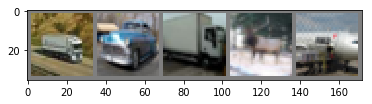

In [49]:
# show images
imshow(vutils.make_grid(images[5:10]))
plt.show()

In [50]:
# print labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(labels[5:10])
print(' '.join('%5s' % classes[labels[j]] for j in range(5,10)))


 9
 1
 9
 4
 0
[torch.LongTensor of size 5]

truck   car truck  deer plane


In [51]:
ginputv = Variable(images[5:10])
ginputv.requires_grad = True
glabelv = Variable(labels[5:10])
goutput = netD(ginputv)
errD_real = criterion(goutput, glabelv)    
errD_real.backward(retain_graph=True)

        # train with fake
        #noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        #noisev = Variable(noise)

fake = netG(Variable(ginputv.grad.data))


#generated = netG(Variable(images[5,10]))

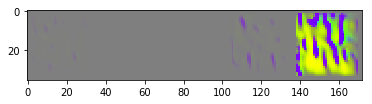

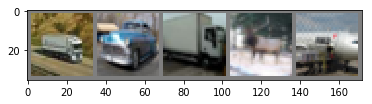


(0 ,0 ,.,.) = 
  1.5293e-01  1.7649e-01  8.3019e-02  ...  -3.5681e-01 -5.0974e-02  8.2353e-02
  2.3133e-01  2.2350e-01 -1.8540e-02  ...  -2.8613e-01 -1.9998e-01 -3.9212e-03
  2.1560e-01  2.1557e-01  2.0748e-02  ...  -3.5670e-01 -2.5490e-01 -2.6274e-01
                 ...                   ⋱                   ...                
 -3.0974e-01 -4.8239e-01 -4.3533e-01  ...   1.2209e-01  1.6097e-01  1.4510e-01
 -4.5085e-01 -3.8826e-01 -2.5494e-01  ...   4.3532e-02  7.4683e-02  9.0213e-02
 -2.0773e-01 -2.9412e-01 -2.6277e-01  ...   4.3341e-02  1.1871e-02  2.7470e-02

(0 ,1 ,.,.) = 
  1.3523e-02  3.3985e-02 -6.2881e-02  ...  -5.5261e-01 -2.7841e-01 -1.7653e-01
  8.2908e-02  7.0352e-02 -1.6160e-01  ...  -4.7343e-01 -4.1160e-01 -2.3142e-01
  4.9408e-02  3.7766e-02 -1.2014e-01  ...  -5.3513e-01 -4.3483e-01 -4.4307e-01
                 ...                   ⋱                   ...                
 -3.6430e-01 -5.2181e-01 -4.7400e-01  ...   2.0542e-02  7.4661e-02  5.7854e-02
 -5.2093e-01 -4.6355

TypeError: imshow() got an unexpected keyword argument 'norm'

In [71]:
imshow(vutils.make_grid(fake.data))
plt.show()
imshow(vutils.make_grid((images[5:10])))
plt.show()
#print(images[5:10])
#print(fake.data.size())
#print(images[5:10] + fake.data)
#perturbed = (images[5:10] + 10*fake.data) + 10
perturbed = (images[5:10] + fake.data)
print(perturbed)
imshow(vutils.make_grid(perturbed),norm=0.5)
plt.show()

In [65]:
outputs = netD(Variable(images[5:10]))

In [66]:
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(5)))

Predicted:    car   car truck  deer plane


In [67]:
outputs2 = netD(Variable(perturbed))

In [68]:
_, predicted2 = torch.max(outputs2.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted2[j]]
                              for j in range(5)))

Predicted:    car   car truck  deer  deer


In [43]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = dset.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


In [44]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = netD(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 62 %


In [46]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    ginputv = Variable(images)
    ginputv.requires_grad = True
    glabelv = Variable(labels)
    goutput = netD(ginputv)
    errD_real = criterion(goutput, glabelv)    
    errD_real.backward(retain_graph=True)

        # train with fake
        #noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        #noisev = Variable(noise)

    fake = netG(Variable(ginputv.grad.data))
    perturbed = fake + ginputv
    outputs = netD(perturbed)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %
